# Analyses of Flights Data

# Overview

The dataset gives us information about delayed flights for three years: 1992,2000 and 2008. We have a breakdown available including reason for delay, duration of delay and the origin/destination airport.

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import os
from jupyterthemes import jtplot

%matplotlib inline

# Gather Data

I downlaoded the data from http://stat-computing.org/dataexpo/2009/the-data.html. I downloaded three years worth of data: 2008, 2000 and 1992. The files were rather huge so i have not attached them but I will outline the process i went through to join the datasets.

In [2]:
if 'flights_data.csv' not in os.listdir():
    # take the steps to create it
    data_2008 = pd.read_csv('flights_2008.csv', encoding = 'utf-8')
    data_2000 = pd.read_csv('flights_2000.csv', encoding = 'utf-8')
    data_1992 = pd.read_csv('flights_1992.csv', encoding = 'utf-8')
    data = pd.concat([data_1992, data_2000,data_2008])
    data.to_csv('flights_data.csv', index=False)

# This data is always loaded
carriers = pd.read_csv('carriers.csv')
data = pd.read_csv('flights_data.csv')

c:\users\bhussain13\documents\main\lib\site-packages\IPython\core\interactiveshell.py:3044: DtypeWarning: Columns (10,22) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


The data set is gigantic and it would be a good idea to clean this at this point to improve the processing speed further down the line. I will start getting rid of columns that will not be used for analysis.

Some questions we will be looking to answer are below:
- What was the average delay time for flights for the 3 years?
- What are the most common reason for delayed flights?
- Is origin related to delayed flights?
- Are flights more commonly delayed on a particular day?
- Has the overall flight performance increased over the years?

It looks like we won't be needing the following columns: FlightNum, TailNum , ActualElapsedTime, CRSElapsedTime, AirTime, Distance, TaxiIn, TaxiOut, DepTime, CRSDepTime, ArrTime . I will proceed to drop these columns

# Clean Data

In [3]:
#Keep original data set and set a copy to clean
data_clean = data.copy()

In [4]:
#Drop the columns we don't need
data_clean = data_clean.drop(columns=['FlightNum','TailNum','ActualElapsedTime',
                                     'CRSElapsedTime','AirTime','Distance','TaxiIn',
                                     'TaxiOut','DepTime','CRSDepTime','ArrTime','CRSArrTime'])

In [5]:
data_clean.head()

,Year,Month,DayofMonth,DayOfWeek,UniqueCarrier,ArrDelay,DepDelay,Origin,Dest,Cancelled,CancellationCode,Diverted,CarrierDelay,WeatherDelay,NASDelay,SecurityDelay,LateAircraftDelay
0,1992,1,2,4,US,5.0,-2.0,CMH,IND,0,NaN,0,NaN,NaN,NaN,NaN,NaN
1,1992,1,3,5,US,-3.0,0.0,CMH,IND,0,NaN,0,NaN,NaN,NaN,NaN,NaN
2,1992,1,4,6,US,-3.0,-3.0,CMH,IND,0,NaN,0,NaN,NaN,NaN,NaN,NaN
3,1992,1,5,7,US,4.0,0.0,CMH,IND,0,NaN,0,NaN,NaN,NaN,NaN,NaN
4,1992,1,6,1,US,-8.0,2.0,CMH,IND,0,NaN,0,NaN,NaN,NaN,NaN,NaN


We only want to look at rows that have a delay value in the last four columns.


Edit:
It looks like we didn't have delay breakdown for previous years, so I will go back and read the old file to do this part. However for further analysis, we can dig deeper into 2008 to understand the different delaying reasons.

In [6]:
data_clean_2008 = data_clean.dropna(subset=['CarrierDelay','WeatherDelay','SecurityDelay','LateAircraftDelay'])

In [7]:
data_clean_2008.sample(5)

,Year,Month,DayofMonth,DayOfWeek,UniqueCarrier,ArrDelay,DepDelay,Origin,Dest,Cancelled,CancellationCode,Diverted,CarrierDelay,WeatherDelay,NASDelay,SecurityDelay,LateAircraftDelay
14925144,2008,7,1,2,AS,18.0,25.0,PDX,OAK,0,NaN,0,0.0,0.0,0.0,0.0,18.0
12065258,2008,3,8,6,XE,316.0,324.0,BHM,IAH,0,NaN,0,316.0,0.0,0.0,0.0,0.0
11591650,2008,2,3,7,UA,42.0,-4.0,IAD,LAX,0,NaN,0,0.0,0.0,42.0,0.0,0.0
13885414,2008,6,22,7,XE,269.0,303.0,EWR,BNA,0,NaN,0,45.0,0.0,0.0,0.0,224.0
17446433,2008,12,24,3,UA,18.0,1.0,DEN,SNA,0,NaN,0,0.0,0.0,18.0,0.0,0.0


In [8]:
data_clean_2008.shape

(1524735, 17)

In [9]:
data_clean_2008['Cancelled'].unique()

array([0], dtype=int64)

In [10]:
data_clean_2008['Year'].unique()

array([2008], dtype=int64)

Since we are only looking at flights that were delayed and not cancelled we can drop those columns too, and we can also drop diverted since we wont be using that in our analysis


In [11]:
data_clean = data_clean.drop(columns=['CancellationCode','Cancelled','Diverted'])

In [12]:
data_clean.shape

(17784932, 14)

Lets bring in the carrier names so know what airlines we are talking about rather than the unique carrier codes

In [13]:
#To get the names of the airlines we need to merge the carrier file to this clean dataset.
#I changed the name of the column in the carrier file from 'Code' to 'Unique Carrier' so we can match easily.
data_clean_2008 = pd.merge(data_clean_2008, carriers, how = 'left', on = 'UniqueCarrier')
data_clean = pd.merge(data_clean, carriers, how = 'left', on = 'UniqueCarrier')

In [14]:
data_clean_2008.sample(5)

,Year,Month,DayofMonth,DayOfWeek,UniqueCarrier,ArrDelay,DepDelay,Origin,Dest,Cancelled,CancellationCode,Diverted,CarrierDelay,WeatherDelay,NASDelay,SecurityDelay,LateAircraftDelay,Description
1025485,2008,8,1,5,XE,71.0,104.0,EWR,CVG,0,NaN,0,71.0,0.0,0.0,0.0,0.0,Expressjet Airlines Inc.
625441,2008,5,18,7,UA,84.0,80.0,LAX,ORD,0,NaN,0,13.0,0.0,4.0,0.0,67.0,United Air Lines Inc.
1258938,2008,10,25,6,AA,18.0,-12.0,PHL,DFW,0,NaN,0,0.0,0.0,18.0,0.0,0.0,American Airlines Inc.
11923,2008,1,23,3,WN,70.0,76.0,BWI,RDU,0,NaN,0,31.0,0.0,0.0,0.0,39.0,Southwest Airlines Co.
977910,2008,7,19,6,AA,102.0,110.0,RSW,ORD,0,NaN,0,0.0,0.0,21.0,0.0,81.0,American Airlines Inc.


In [15]:
data_clean.to_csv('data_clean.csv', index = False)
data_clean_2008.to_csv('data_clean_2008.csv', index=False)

# Explore Data

Lets create a histogram for the three years on ArrDelay as that looks like the total delay time

## Delay times distribution

The total number of delays has increased, and the distribution has got less skewed over the years as flights are delayed for longer

In [16]:
jtplot.style(figsize = (14.70,8.27))

In [17]:
bin_list = np.arange(0, data_clean['ArrDelay'].max()+10, 10)
base_color = sns.color_palette()[0]
sns.set(style="white", context="notebook",rc={'figure.figsize':(10,10)})

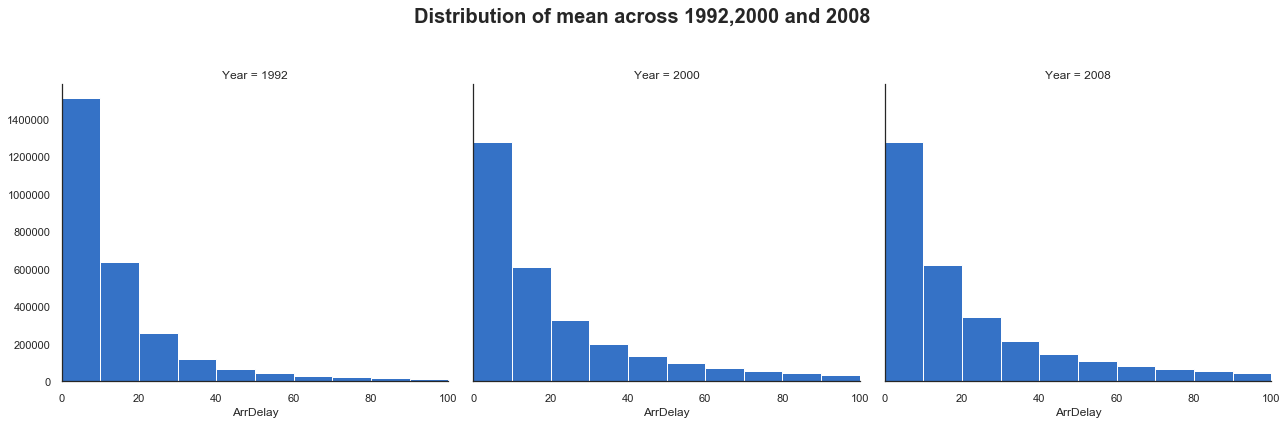

In [18]:
#create a histogram to check the distribution of mean across the different years
g = sns.FacetGrid(data_clean, col='Year', margin_titles = True, height = 6)
g.map(plt.hist, 'ArrDelay',color = base_color, bins= bin_list)
g.fig.subplots_adjust(top=0.8)
g.fig.suptitle('Distribution of mean across 1992,2000 and 2008', fontsize = 20, weight = 'bold')
plt.xlim(0,100);

In [19]:
#This doesn't work
print("total delays \n" + 
      "2008: " + str(len(data_clean.query("Year == 2008 & ArrDelay != 0"))/len(data_clean.query("Year == 2008"))), 
      "\n2000: " + str(len(data_clean.query("Year == 2000 & ArrDelay != 0"))/len(data_clean.query("Year == 2000"))),
      "\n1992: " +  str(len(data_clean.query("Year == 1992 & ArrDelay != 0"))/len(data_clean.query("Year == 1992"))))

total delays 
2008: 0.9736196611337844 
2000: 0.9596491107675161 
1992: 0.9525531125611406


We can look at the statistics in more detail with a box plot

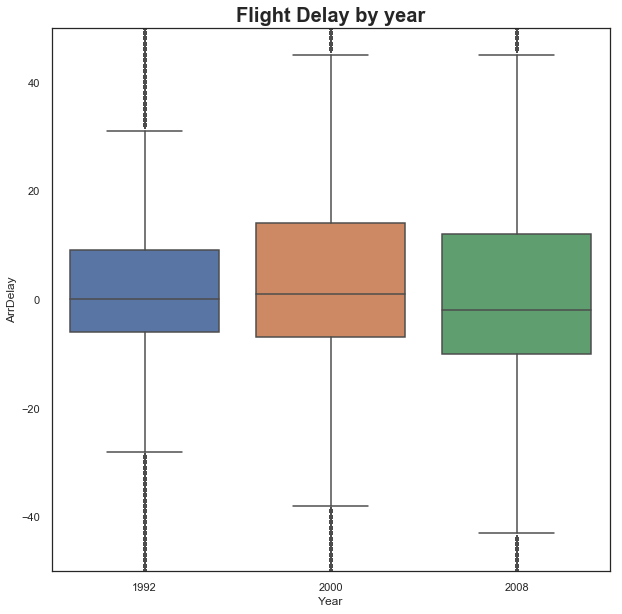

In [20]:
# A boxplot to show how the spectrum has got wider of the delay times, and how we have more flights in the 
# interquartile range
ax = sns.boxplot(y="ArrDelay", x='Year', data= data_clean)
plt.ylim(-50,50)
plt.title('Flight Delay by year', fontsize = 20, weight = 'bold');

It is clear that even though the average Delay time has decreased over the years, the range of delayed flights has increased. Meaning the spectrum has widened, the longest and the shortest delayed have increased.

Text(0.5, 1.0, 'Flight Delay by year')

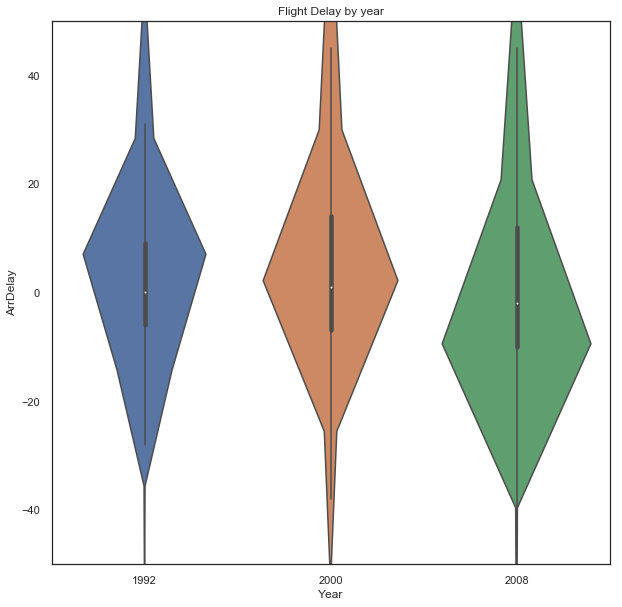

In [21]:
# Lets see if violin plot demonstrates this point better
ax = sns.violinplot(y="ArrDelay", x='Year', data= data_clean )
plt.ylim(-50,50)
plt.title('Flight Delay by year')

Putting away the cross year comparison, and focusing more on 2008, we can dig deeper on a more granular level.

In [22]:
data_clean_2008.head()

,Year,Month,DayofMonth,DayOfWeek,UniqueCarrier,ArrDelay,DepDelay,Origin,Dest,Cancelled,CancellationCode,Diverted,CarrierDelay,WeatherDelay,NASDelay,SecurityDelay,LateAircraftDelay,Description
0,2008,1,3,4,WN,34.0,34.0,IND,BWI,0,NaN,0,2.0,0.0,0.0,0.0,32.0,Southwest Airlines Co.
1,2008,1,3,4,WN,57.0,67.0,IND,LAS,0,NaN,0,10.0,0.0,0.0,0.0,47.0,Southwest Airlines Co.
2,2008,1,3,4,WN,80.0,94.0,IND,MCO,0,NaN,0,8.0,0.0,0.0,0.0,72.0,Southwest Airlines Co.
3,2008,1,3,4,WN,15.0,27.0,IND,PHX,0,NaN,0,3.0,0.0,0.0,0.0,12.0,Southwest Airlines Co.
4,2008,1,3,4,WN,16.0,28.0,IND,TPA,0,NaN,0,0.0,0.0,0.0,0.0,16.0,Southwest Airlines Co.


In [23]:
#create a new dataframe to to make the heatmap
df_2008_heatmap_day = data_clean_2008.filter(items=['DayOfWeek','WeatherDelay','CarrierDelay','NASDelay','SecurityDelay','LateAircraftDelay'])

In [24]:
df_2008_heatmap_day=df_2008_heatmap_day.set_index('DayOfWeek') 

In [25]:
df_2008_heatmap_day.sample(5)

,WeatherDelay,CarrierDelay,NASDelay,SecurityDelay,LateAircraftDelay
DayOfWeek,,,,,
1,0.0,21.0,0.0,0.0,7.0
4,0.0,284.0,0.0,0.0,0.0
1,0.0,0.0,18.0,0.0,0.0
5,0.0,0.0,79.0,0.0,0.0
2,0.0,0.0,2.0,0.0,36.0


In [26]:
pivot_2008_heatmap_day  = pd.pivot_table(df_2008_heatmap_day, index = df_2008_heatmap_day.index ,aggfunc= lambda x: (x[x!= 0]).mean())

In [27]:
pivot_2008_heatmap_day

,CarrierDelay,LateAircraftDelay,NASDelay,SecurityDelay,WeatherDelay
DayOfWeek,,,,,
1,36.890100,45.532500,27.436558,17.188422,45.358774
2,36.809477,46.035724,30.552165,19.067723,46.258028
3,36.169738,42.966189,27.672771,18.500620,44.155056
4,33.775200,42.912387,27.040529,17.841751,44.414658
5,33.727510,45.384067,28.359710,18.433102,44.963329
6,38.063226,45.112636,26.059475,20.696846,47.859740
7,36.539564,48.876308,29.766140,17.256137,51.938998


## Heatmap for delay distribution

The longest delays are usually due to the weather or Aircraft Delay. The longest and most frequent delays are seen in July and December, also peaking around March. These align to the holiday season and to adverse weather conditions as well.

In [28]:
#Instead of using this everytime, i wrote this function for the next three graphs.
def heatmap(table):
    f, ax = plt.subplots(figsize=(12, 8))
    g = sns.heatmap(table, annot=True, linewidths=.5, ax=ax, cmap =sns.light_palette((260, 75, 60), input="husl"));
    plt.xticks(color = 'black', fontsize = 10)
    plt.yticks(color = 'black', fontsize = 10)
    ax.yaxis.label.set_visible(False)

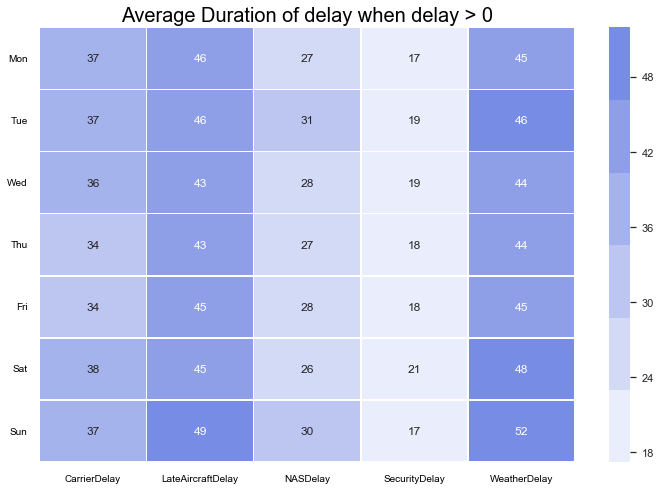

In [29]:
# Weather and Late Aircraft have the longest Delay when we compare across the week by types of delays
heatmap(pivot_2008_heatmap_day)
plt.yticks(np.arange(7)+0.5,('Mon','Tue','Wed','Thu','Fri','Sat','Sun'), rotation=0, fontsize=10, va="center");
plt.title('Average Duration of delay when delay > 0', color = 'black', fontsize = 20);

In [30]:
df_2008_heatmap_month= data_clean_2008.filter(items=['Month','WeatherDelay','CarrierDelay','NASDelay','SecurityDelay','LateAircraftDelay'])

In [31]:
df_2008_heatmap_month = df_2008_heatmap_month.set_index('Month')

In [32]:
pivot_2008_heatmap_month  = pd.pivot_table(df_2008_heatmap_month, index = df_2008_heatmap_month.index ,
                                           aggfunc= lambda x: (x[x!= 0]).mean())

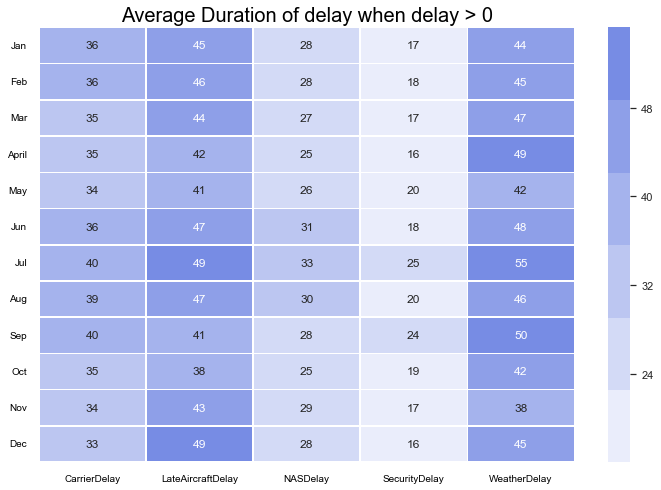

In [33]:
heatmap(pivot_2008_heatmap_month)
plt.yticks(np.arange(12)+0.5,('Jan','Feb','Mar','April','May','Jun','Jul','Aug','Sep','Oct','Nov','Dec'), rotation=0, fontsize=10, va="center", color = 'black');
plt.title('Average Duration of delay when delay > 0', color = 'black', fontsize = 20);
# July December, and March stand out 

In [34]:
pivot_2008_heatmap_month  = pd.pivot_table(df_2008_heatmap_month, index = df_2008_heatmap_month.index ,aggfunc= lambda x: (x[x!= 0]).count()/1000)

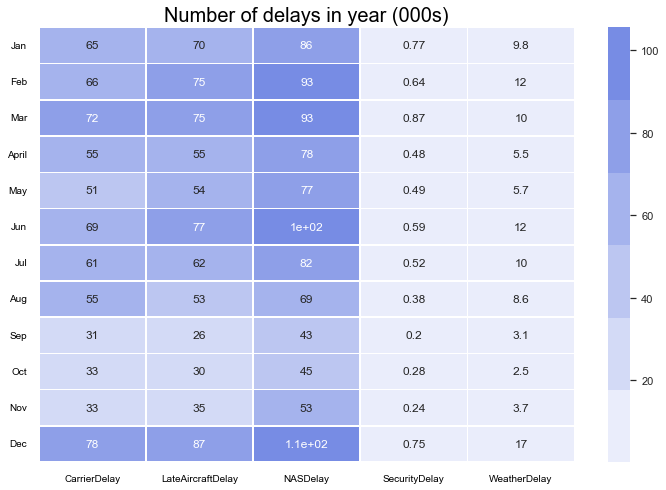

In [35]:
heatmap(pivot_2008_heatmap_month)
plt.yticks(np.arange(12)+0.5,('Jan','Feb','Mar','April','May','Jun','Jul','Aug','Sep','Oct','Nov','Dec'), rotation=0, fontsize=10, va="center", color = 'black');
plt.title('Number of delays in year (000s)', color = 'black', fontsize = 20);
#same result as graph before where July, December and March stand out

In [36]:
len(data_clean_2008['Description'].unique())

20

We can look at the distribution of delay time across the different airlines

In [37]:
# Replace the US airways name as it is too long in the legend
df_2008_airlines = data_clean_2008.filter(items=['Description','ArrDelay','Origin'])
df_2008_airlines['Description'] = df_2008_airlines['Description'].replace(
    'US Airways Inc. (Merged with America West 9/05. Reporting for both starting 10/07.)','US Airways')

In [38]:
#See how many airlines we are dealing with and see if US aiways name is now normal
df_2008_airlines['Description'].unique()

array(['Southwest Airlines Co.', 'Expressjet Airlines Inc.',
       'Mesa Airlines Inc.', 'Comair Inc.', 'Skywest Airlines Inc.',
       'United Air Lines Inc.', 'US Airways', 'Delta Air Lines Inc.',
       'Atlantic Southeast Airlines', 'Frontier Airlines Inc.',
       'AirTran Airways Corporation', 'Hawaiian Airlines Inc.',
       'American Eagle Airlines Inc.', 'Northwest Airlines Inc.',
       'Pinnacle Airlines Inc.', 'American Airlines Inc.',
       'Aloha Airlines Inc.', 'Alaska Airlines Inc.', 'JetBlue Airways',
       'Continental Air Lines Inc.'], dtype=object)

## Distribution by airline

Southwest Airline had the most delay instances while Aloha Airlines had the least, although the first graph does not account for the number of flights so this result could be skewed. The FacetGrid shows the distribution by origin airport as we can see that Atlanta and Orlando experience significant amount of delayed departures from the airport. Different airlines have different hubs where they are the most frequently delayed. The swarm graph shows us the ranking of the different types of delay by airline. Alaska Airlines and Aloha Airlines(only 394 delayed flights) suffer the most carrier delay which is the only type of delay caused by the Airline itself while Frontier airline is the best at avoiding carrier delay relative to other types of delays.

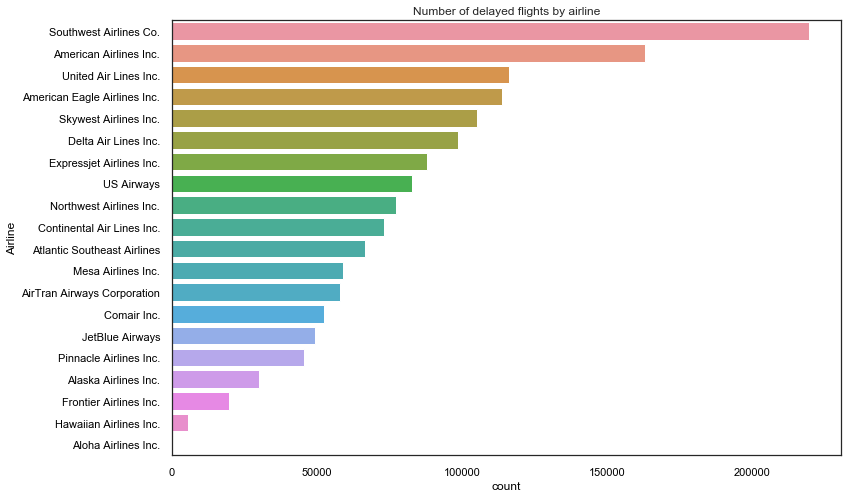

In [39]:
# Create a bar chart to compare the amount of delayed flights by airline
f, ax = plt.subplots(figsize=(12, 8))
ax = sns.countplot(y="Description", data=df_2008_airlines, order = df_2008_airlines['Description'].value_counts(ascending=False).index)
ax.set(ylabel ='Airline')
ax.yaxis.label.set_color('black')
ax.xaxis.label.set_color('black')
ax.set_title('Number of delayed flights by airline')
ax.tick_params(colors='black');

In [40]:
 data_clean_2008.groupby('Description')['ArrDelay'].count().sort_values(ascending = False)[:9]

Description
Southwest Airlines Co.                                                                 219757
American Airlines Inc.                                                                 163024
United Air Lines Inc.                                                                  116072
American Eagle Airlines Inc.                                                           113672
Skywest Airlines Inc.                                                                  105245
Delta Air Lines Inc.                                                                    98840
Expressjet Airlines Inc.                                                                87883
US Airways Inc. (Merged with America West 9/05. Reporting for both starting 10/07.)     82933
Northwest Airlines Inc.                                                                 77218
Name: ArrDelay, dtype: int64

In [41]:
 data_clean_2008.groupby('Origin')['ArrDelay'].count().sort_values(ascending = False)[:9]

Origin
ATL    104880
ORD    104365
DFW     70499
DEN     55389
EWR     45520
DTW     41202
IAH     40194
LAX     39902
PHX     36152
Name: ArrDelay, dtype: int64

In [42]:
origin = ['ATL','ORD','DFW','DEN','EWR','DTW','IAH','LAX','PHX']

In [43]:
df_2008_airlines = df_2008_airlines[df_2008_airlines['Origin'].isin(origin)]

In [44]:
df_2008_airlines.head()

,Description,ArrDelay,Origin
161,Southwest Airlines Co.,15.0,LAX
162,Southwest Airlines Co.,32.0,LAX
163,Southwest Airlines Co.,42.0,LAX
164,Southwest Airlines Co.,22.0,LAX
165,Southwest Airlines Co.,96.0,LAX


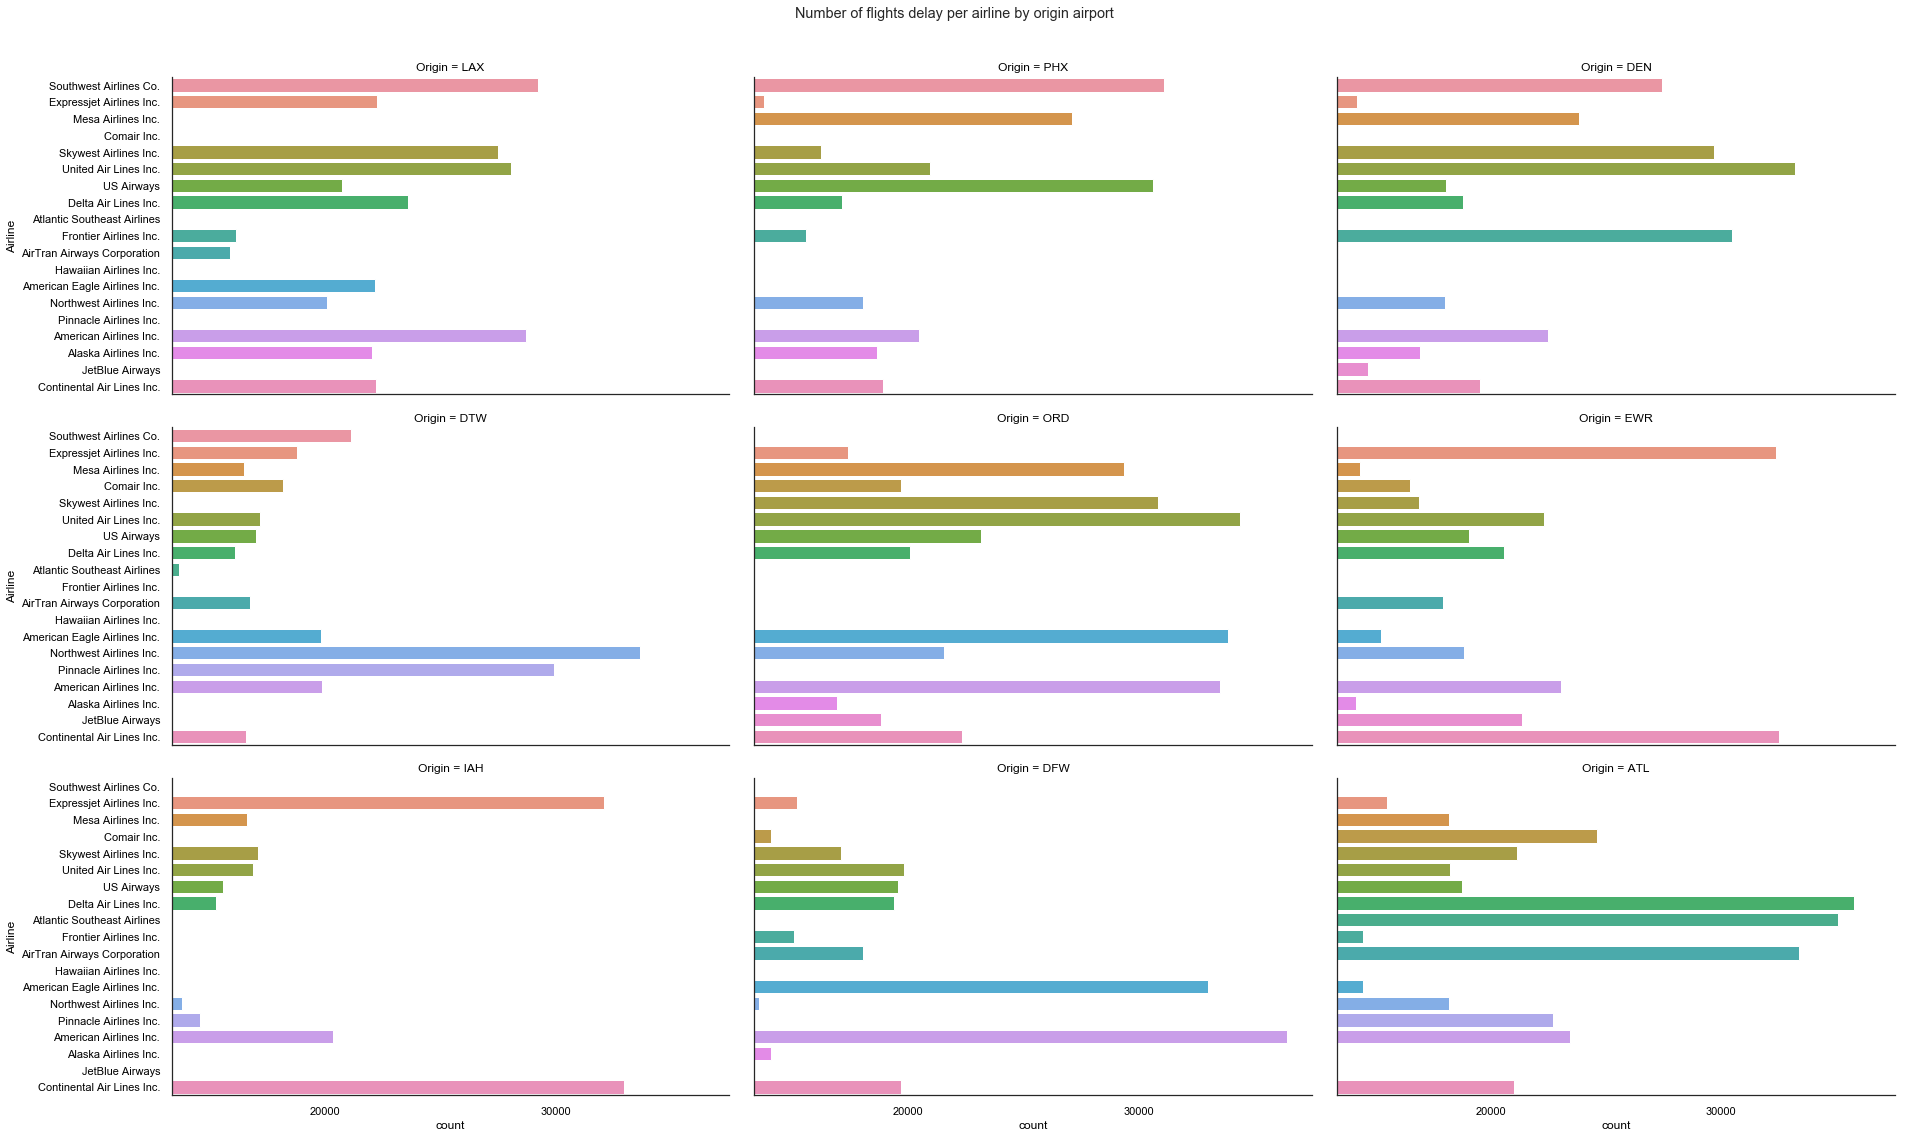

In [45]:
#Facetgrid showing the delayed departures from different airports using a log scale
g = sns.catplot(y='Description',col='Origin',data = df_2008_airlines, kind='count', col_wrap=3,height = 5,  aspect = (14.70/3)/(8.27/3))
g.set(xscale="log")
g.set_ylabels(label ='Airline', color = 'black')
g.set_xlabels(color = 'black')
g.set_titles(color = 'black')
g.set_yticklabels(color='black')
g.set_xticklabels(color='black')
plt.suptitle("Number of flights delay per airline by origin airport", y =1.04);

For the top 3 most frequently late airlines we can have a look at the reasoning for the delays

In [46]:
df_2008_airlines['Description'].unique()

array(['Southwest Airlines Co.', 'Expressjet Airlines Inc.',
       'Mesa Airlines Inc.', 'Comair Inc.', 'Skywest Airlines Inc.',
       'United Air Lines Inc.', 'US Airways', 'Delta Air Lines Inc.',
       'Atlantic Southeast Airlines', 'Frontier Airlines Inc.',
       'AirTran Airways Corporation', 'Hawaiian Airlines Inc.',
       'American Eagle Airlines Inc.', 'Northwest Airlines Inc.',
       'Pinnacle Airlines Inc.', 'American Airlines Inc.',
       'Alaska Airlines Inc.', 'JetBlue Airways',
       'Continental Air Lines Inc.'], dtype=object)

In [47]:
airlines = ['Southwest Airlines Co.','American Airlines Inc.','United Air Lines Inc.']
df_2008_airlines_heatmap = data_clean_2008.filter(items=['Description','WeatherDelay','CarrierDelay','NASDelay','SecurityDelay','LateAircraftDelay'])

In [48]:
df_2008_airlines_heatmap = df_2008_airlines_heatmap[df_2008_airlines_heatmap['Description'].isin(airlines)]

In [49]:
df_2008_airlines_heatmap = df_2008_airlines_heatmap.set_index('Description')

In [50]:
df_2008_airlines_heatmap_test = pd.DataFrame(df_2008_airlines_heatmap.unstack(level=0))

In [51]:
final_heatmap = df_2008_airlines_heatmap_test.reset_index()

In [52]:
final_heatmap = final_heatmap.rename(columns = {'level_0':'Type of delay','Description':'Airline',0:'Delay(mins)'})

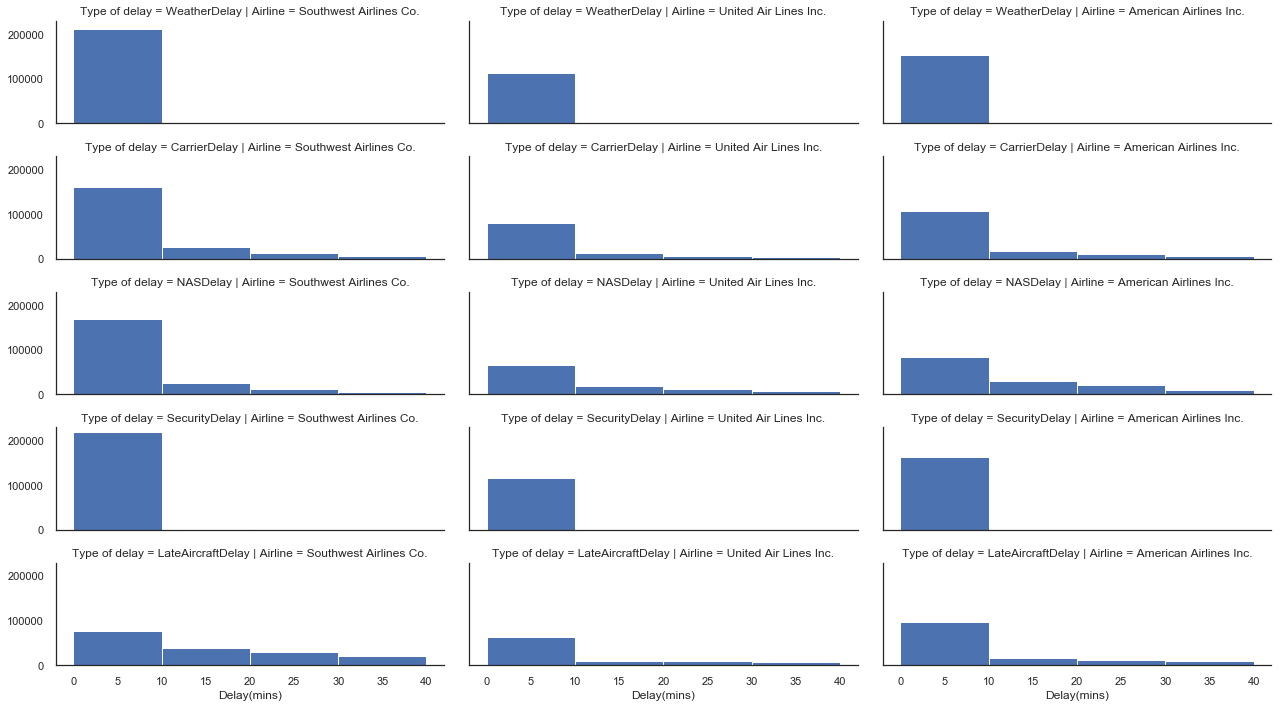

In [53]:
g = sns.FacetGrid(final_heatmap, row='Type of delay',col='Airline',height=2, aspect=3)
bins = np.arange(0, 50, 10)
g.map(plt.hist, "Delay(mins)", bins=bins);

Graph is not very affective in conveying the message

Given that CarrierDelay is one of the only delays that is in the control of airlines, we can look at how all the different airlines perform in this department and we can also look at the precentage of delayed flights by airline

In [54]:
data_clean_2008.sample(5)

,Year,Month,DayofMonth,DayOfWeek,UniqueCarrier,ArrDelay,DepDelay,Origin,Dest,Cancelled,CancellationCode,Diverted,CarrierDelay,WeatherDelay,NASDelay,SecurityDelay,LateAircraftDelay,Description
1131185,2008,9,10,3,WN,15.0,20.0,DAL,MSY,0,NaN,0,9.0,0.0,0.0,0.0,6.0,Southwest Airlines Co.
829720,2008,6,13,5,AA,26.0,-4.0,SAT,ORD,0,NaN,0,0.0,0.0,26.0,0.0,0.0,American Airlines Inc.
278604,2008,2,4,1,AA,239.0,223.0,LAS,DFW,0,NaN,0,223.0,0.0,16.0,0.0,0.0,American Airlines Inc.
1378311,2008,12,26,5,WN,154.0,157.0,OMA,PHX,0,NaN,0,5.0,0.0,0.0,0.0,149.0,Southwest Airlines Co.
1294030,2008,11,26,3,OH,106.0,120.0,GRR,CVG,0,NaN,0,106.0,0.0,0.0,0.0,0.0,Comair Inc.


In [55]:
carrier_delay = data_clean_2008.filter(items=['Description','ArrDelay','WeatherDelay','CarrierDelay','NASDelay','SecurityDelay','LateAircraftDelay'])

In [56]:
carrier_delay_pivot = pd.pivot_table(carrier_delay, index = 'Description', aggfunc = 'sum')

In [57]:
carrier_delay_pivot['% CarrierDelay'] = (carrier_delay_pivot['CarrierDelay'] / carrier_delay_pivot['ArrDelay']) * 100
carrier_delay_pivot['% WeatherDelay'] = (carrier_delay_pivot['WeatherDelay'] / carrier_delay_pivot['ArrDelay']) * 100
carrier_delay_pivot['% NASDelay'] = (carrier_delay_pivot['NASDelay'] / carrier_delay_pivot['ArrDelay']) * 100
carrier_delay_pivot['% SecurityDelay'] = (carrier_delay_pivot['SecurityDelay'] / carrier_delay_pivot['ArrDelay']) * 100
carrier_delay_pivot['% LateAircraftDelay'] = (carrier_delay_pivot['LateAircraftDelay'] / carrier_delay_pivot['ArrDelay']) * 100

In [58]:
carrier_delay_plot =carrier_delay_pivot.drop(columns=['ArrDelay','ArrDelay','WeatherDelay','CarrierDelay','NASDelay','SecurityDelay','LateAircraftDelay'])

In [59]:
delay_df = pd.DataFrame(carrier_delay_plot.unstack(level=0)).reset_index()

In [60]:
delay_df = delay_df.rename(columns={'level_0':'Delay',0:'%'})

In [61]:
delay_df['Description'] = delay_df['Description'].replace('US Airways Inc. (Merged with America West 9/05. Reporting for both starting 10/07.)',
                                                              'US Airways')

c:\users\bhussain13\documents\main\lib\site-packages\seaborn\categorical.py:2974: UserWarning: The `split` parameter has been renamed to `dodge`.
  warnings.warn(msg, UserWarning)


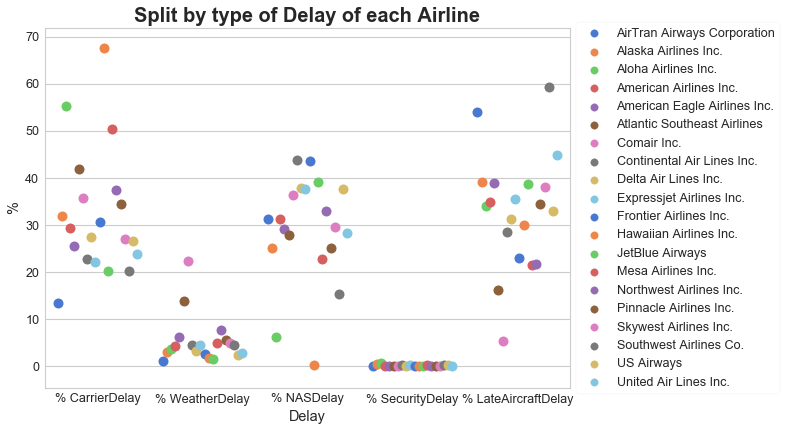

In [62]:
jtplot.style(figsize = (14.70,8.27))
ax = sns.swarmplot(x='Delay',  y='%', data=delay_df, hue='Description', split=True, size = 10, palette='muted')
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
box = ax.get_position()
ax.set_position([box.x0, box.y0, box.width * 0.8, box.height])
plt.title('Split by type of Delay of each Airline', fontsize = 20, weight = 'bold')
plt.show()

# Results

 - The distribution of delays has changed over the years. Flights are now more frequently delayed for longer
 - Sunday had the longest average delays while June and December stood out for the delay by months. The total number of delays was also the largest in June
 - SouthWest Airlines stood out as the airline with most delays even followed by American Airlines.
 - Delta and Atlantic were the most frequently delayed leaving Atlanta Airport while SouthWest airline had was more distributed across different airports
 - Air Trans and Southwest also faired badly in the reasoning for delay, as that is one of the only types of Delay that is in the control of airlines themselves.